/tmp/ipykernel_101314/3581979883.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Technology", y="UMI per Cell", data=df_lps,
/tmp/ipykernel_101314/3581979883.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Technology", y="UMI per Cell", data=df_pbs,


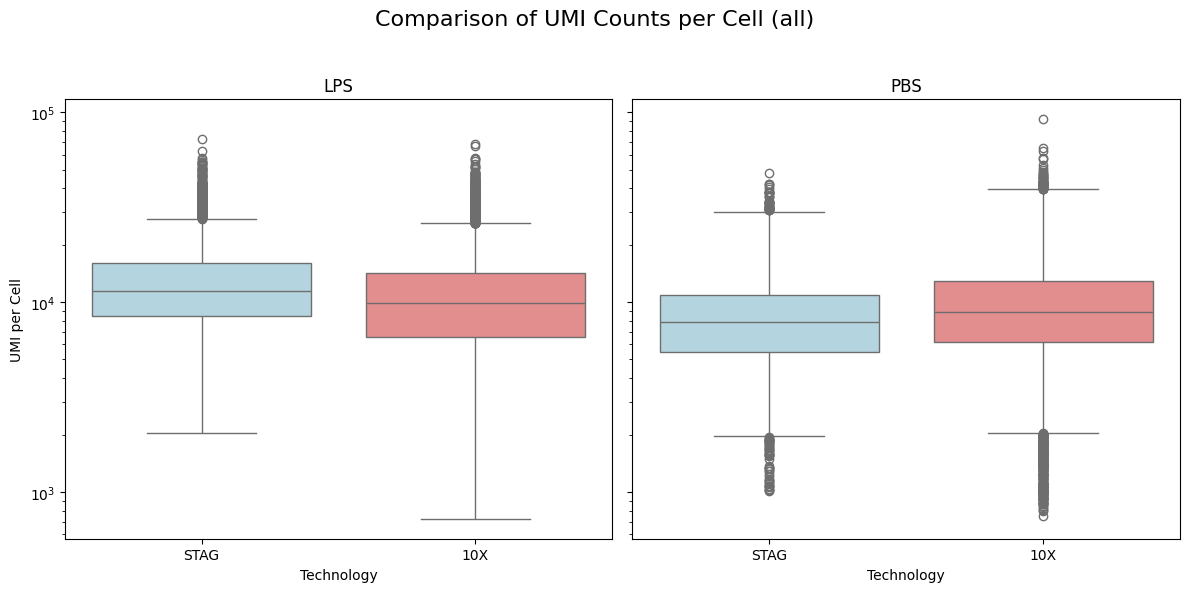

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import os

def read_and_preprocess_10x_data(data_path):
    """
    Read 10x data as an AnnData object and convert gene names to uppercase.
    Avoid converting the full count matrix to pandas.
    """
    adata = sc.read_10x_mtx(data_path)
    sc.pp.filter_cells(adata, min_counts=1000)
    adata.var_names = adata.var_names.str.upper()
    return adata

def read_and_preprocess_STAG(stag_path):
    """
    Read STAG-seq data as an AnnData object and convert gene names to uppercase.
    """
    adata = sc.read(stag_path)
    adata.var_names = adata.var_names.str.upper()
    return adata

def load_and_process(stag_path, tenx_path):
    """
    Load the two datasets, restrict to shared genes (without converting
    the full matrix), and compute UMI per cell for each dataset.
    """
    adata_stag = read_and_preprocess_STAG(stag_path)
    adata_10x  = read_and_preprocess_10x_data(tenx_path)
    
    # Find shared genes between the two datasets
    shared_genes = np.intersect1d(adata_stag.var_names, adata_10x.var_names)
    
    # Subset AnnData objects to shared genes
    adata_stag = adata_stag[:, shared_genes].copy()
    adata_10x  = adata_10x[:, shared_genes].copy()
    
    # Compute UMI per cell using sparse matrix operations
    umi_stag = np.squeeze(np.asarray(adata_stag.X.sum(axis=1)))
    umi_10x = np.squeeze(np.asarray(adata_10x.X.sum(axis=1)))
    
    # Create a small DataFrame for plotting (the aggregated data are relatively small)
    import pandas as pd  # using pandas here on the aggregated results is acceptable
    df = pd.DataFrame({
        "UMI per Cell": np.concatenate([umi_stag, umi_10x]),
        "Technology": ["STAG"] * len(umi_stag) + ["10X"] * len(umi_10x)
    })
    return df

def main_combined(lps_stag_path, lps_tenx_path, pbs_stag_path, pbs_tenx_path, condition, save_path="./"):
    # Process LPS dataset
    df_lps = load_and_process(lps_stag_path, lps_tenx_path)
    df_lps["Condition"] = "LPS"
    
    # Process PBS dataset
    df_pbs = load_and_process(pbs_stag_path, pbs_tenx_path)
    df_pbs["Condition"] = "PBS"
    
    # Create side-by-side boxplots using subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    sns.boxplot(x="Technology", y="UMI per Cell", data=df_lps,
                palette=["lightblue", "lightcoral"], ax=axes[0])
    axes[0].set_title("LPS")
    axes[0].set_xlabel("Technology")
    axes[0].set_ylabel("UMI per Cell")
    axes[0].set_yscale("log")
    
    sns.boxplot(x="Technology", y="UMI per Cell", data=df_pbs,
                palette=["lightblue", "lightcoral"], ax=axes[1])
    axes[1].set_title("PBS")
    axes[1].set_xlabel("Technology")
    axes[1].set_yscale("log")
    
    plt.suptitle(f"Comparison of UMI Counts per Cell ({condition})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(os.path.join(save_path, f"{condition}_umi_per_cell_combined.png"), dpi=300, bbox_inches='tight')
    # plt.savefig(os.path.join(save_path, f"{condition}_umi_per_cell_combined.svg"), dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

if __name__ == "__main__":
    # Example paths; adjust these to your actual file locations.
    LPS_tenx_path_1  = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_41_029"
    LPS_stag_path    = "/mnt/data/project/25_02_25_whole_transcriptomics/result/LPS/merged_LPS.h5ad"

    PBS_tenx_path_1  = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_39_027"
    PBS_stag_path    = "/mnt/data/project/25_02_25_whole_transcriptomics/result/PBS/Annotated_phenotype_hypr_seq.h5ad"

    # save_path = "boxplot_umi_per_cell"
    # if not os.path.exists(save_path):
    #     os.makedirs(save_path)
    
    # For combined plots (side-by-side boxplots for LPS and PBS):
    main_combined(
        lps_stag_path=LPS_stag_path, 
        lps_tenx_path=LPS_tenx_path_1, 
        pbs_stag_path=PBS_stag_path, 
        pbs_tenx_path=PBS_tenx_path_1, 
        condition="all", 
    )
    


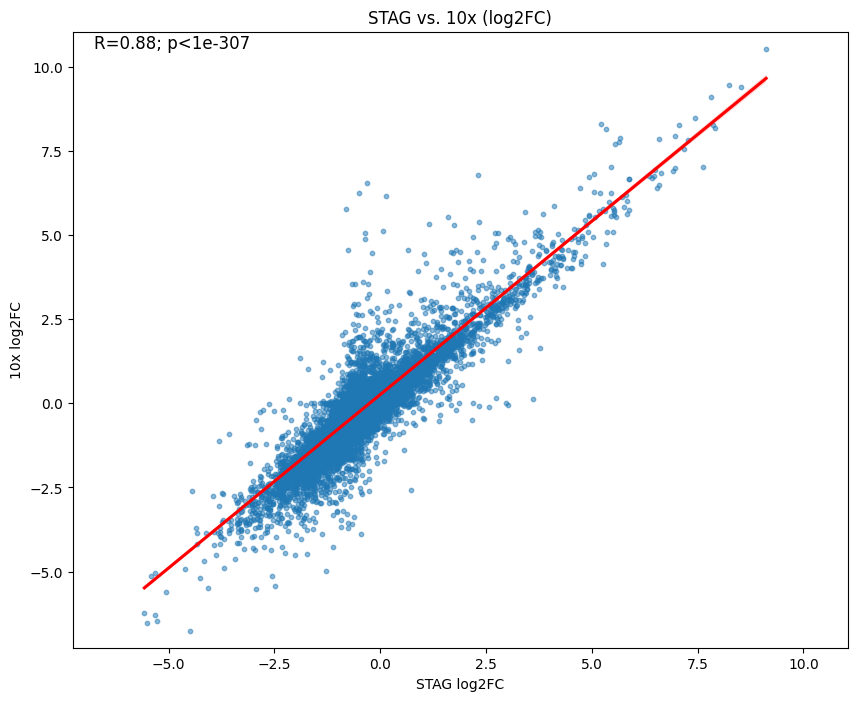

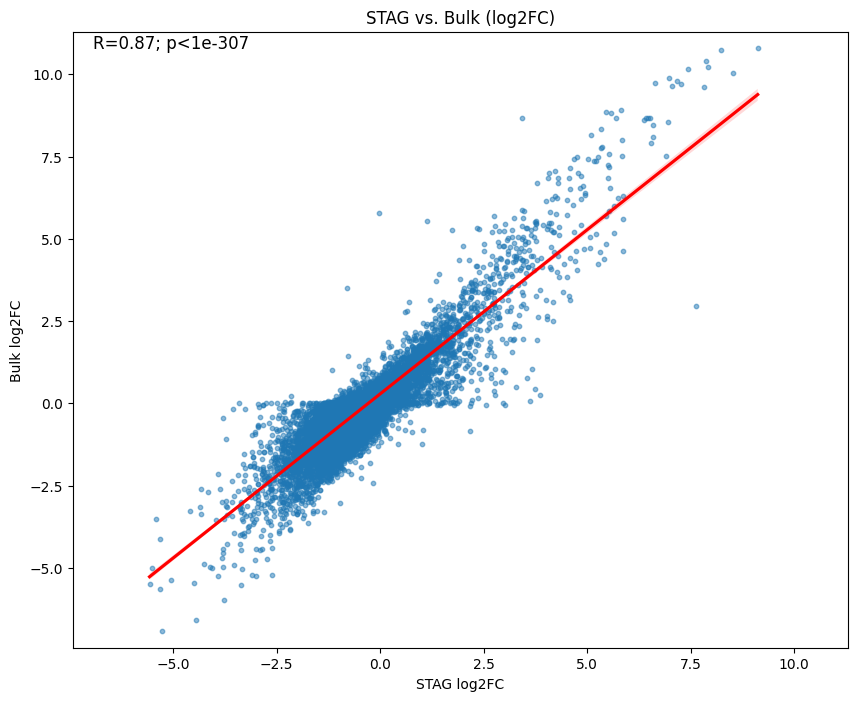

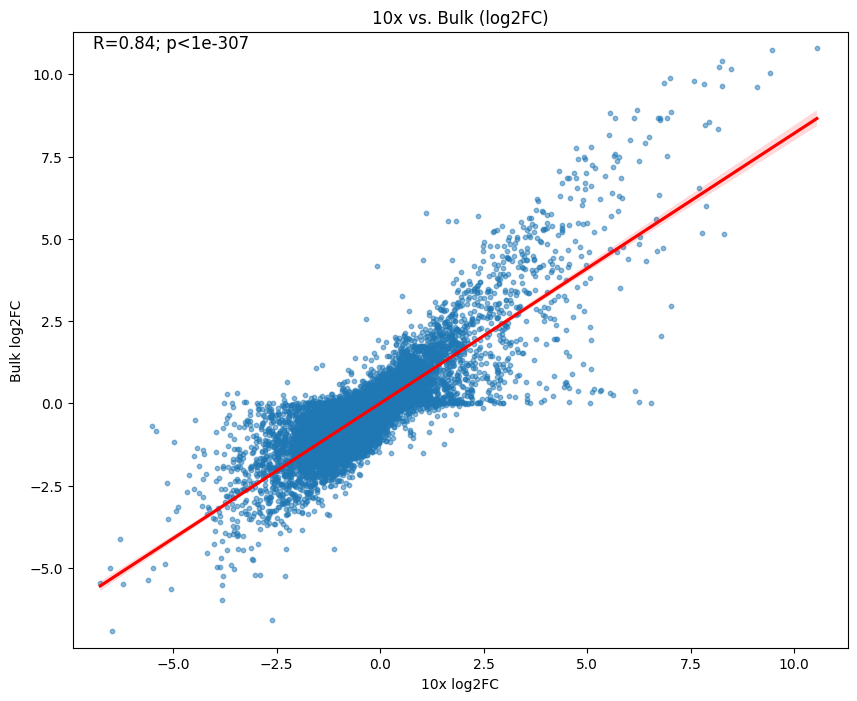

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
#                                DATA READERS
# ------------------------------------------------------------------------------
def read_and_preprocess_10x_data(data_path):
    adata = sc.read_10x_mtx(data_path)
    sc.pp.normalize_total(adata, target_sum=1e6)

    # Convert to pandas
    count_10x = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)
    count_10x.columns = count_10x.columns.str.upper()

    # Pseudo-bulk: average across all cells
    pseudo_count_10x = count_10x.mean(axis=0)
    return count_10x, pseudo_count_10x

def read_and_preprocess_bulk_table(bulk_file_path):
    """
    Read and preprocess the bulk file, returning a DataFrame with columns:
      [
        "GENE", 
        "Sum_LPS", "Sum_PBS",
        "CPM_LPS", "CPM_PBS",
        "log2_CPM_LPS", "log2_CPM_PBS"
      ]
    """
    table = pd.read_csv(bulk_file_path)
    # Calculate the total counts per condition for normalization
    total_LPS_counts = table[['MDM_LPS1', 'MDM_LPS2', 'MDM_LPS3']].sum().sum()
    total_PBS_counts = table[['MDM_PBS1', 'MDM_PBS2', 'MDM_PBS3']].sum().sum()

    # Sum the counts for each gene across the LPS and PBS samples
    table['Sum_LPS'] = table[['MDM_LPS1', 'MDM_LPS2', 'MDM_LPS3']].sum(axis=1)
    table['Sum_PBS'] = table[['MDM_PBS1', 'MDM_PBS2', 'MDM_PBS3']].sum(axis=1)

    # Calculate CPM for each gene
    table['CPM_LPS'] = (table['Sum_LPS'] / total_LPS_counts) * 1e6
    table['CPM_PBS'] = (table['Sum_PBS'] / total_PBS_counts) * 1e6

    # log2 transform
    table['log2_CPM_LPS'] = np.log2(table['CPM_LPS'] + 1)
    table['log2_CPM_PBS'] = np.log2(table['CPM_PBS'] + 1)
    
    # Make sure GENE is uppercase
    table["GENE"] = table["GENE"].str.upper()
    return table

def read_and_preprocess_STAG_pseudobulk(stag_path):
    """
    Read the STAG-seq data, normalize, return a (count_df, pseudo_bulk) pair.
    """
    LPS_scanpy = sc.read(stag_path)
    sc.pp.normalize_total(LPS_scanpy, target_sum=1e6)

    # Convert to pandas
    count_stag = pd.DataFrame(LPS_scanpy.X, columns=LPS_scanpy.var_names)
    count_stag.columns = count_stag.columns.str.upper()

    # Pseudo-bulk: average across all cells
    pseudoBulk_stag = count_stag.mean(axis=0)
    return count_stag, pseudoBulk_stag

# ------------------------------------------------------------------------------
#                           UNIFIED MERGE FUNCTION
# ------------------------------------------------------------------------------

def compute_log2FC_all(
    bulk_table: pd.DataFrame,
    pseudoBulk_LPS_stag: pd.Series, 
    pseudoBulk_PBS_stag: pd.Series,
    pseudoBulk_LPS_10x: pd.Series,
    pseudoBulk_PBS_10x: pd.Series
) -> pd.DataFrame:
    """
    Computes log2 fold changes (LPS vs. PBS) for Bulk, STAG, and 10x.

    Returns a DataFrame (indexed by gene) with columns:
      ["log2FC_bulk", "log2FC_stag", "log2FC_10x"]
    for the *common genes* found in all three data sources.

    Bulk log2FC is computed from CPM columns in 'bulk_table':
      log2FC_bulk[G] = log2( (CPM_LPS[G] + 1) / (CPM_PBS[G] + 1) )

    STAG/10x log2FC is computed from their pseudo-bulk vectors:
      log2FC_stag[G] = log2( (LPS_stag[G] + 1) / (PBS_stag[G] + 1) )
      log2FC_10x[G]  = log2( (LPS_10x[G]  + 1) / (PBS_10x[G]  + 1) )
    """
    # 1) Bulk: set index to "GENE"
    bulk_indexed = bulk_table.set_index("GENE")

    # 2) Intersection of genes
    #    Note: for Bulk we have 'bulk_indexed.index' 
    #          for STAG/10x we have pseudoBulk_X.index
    common_genes = (
        bulk_indexed.index
        .intersection(pseudoBulk_LPS_stag.index)
        .intersection(pseudoBulk_PBS_stag.index)
        .intersection(pseudoBulk_LPS_10x.index)
        .intersection(pseudoBulk_PBS_10x.index)
    )

    # 3) Subset everything to these common genes
    bulk_sub = bulk_indexed.loc[common_genes]
    LPS_stag_sub = pseudoBulk_LPS_stag[common_genes]
    PBS_stag_sub = pseudoBulk_PBS_stag[common_genes]
    LPS_10x_sub  = pseudoBulk_LPS_10x[common_genes]
    PBS_10x_sub  = pseudoBulk_PBS_10x[common_genes]

    # 4) Compute log2FC for Bulk from CPM
    #    log2FC_bulk = log2( (CPM_LPS +1) / (CPM_PBS +1) )
    log2FC_bulk = np.log2(
        (bulk_sub["CPM_LPS"] + 1) / (bulk_sub["CPM_PBS"] + 1)
    )

    # 5) Compute log2FC for STAG
    #    log2FC_stag = log2( (LPS_stag + 1) / (PBS_stag + 1) )
    log2FC_stag = np.log2(
        (LPS_stag_sub + 1) / (PBS_stag_sub + 1)
    )

    # 6) Compute log2FC for 10x
    log2FC_10x = np.log2(
        (LPS_10x_sub + 1) / (PBS_10x_sub + 1)
    )

    # 7) Create a DataFrame from these 3 vectors
    df_log2FC = pd.DataFrame({
        "log2FC_bulk": log2FC_bulk,
        "log2FC_stag": log2FC_stag,
        "log2FC_10x":  log2FC_10x
    }, index=common_genes)

    return df_log2FC


def plot_log2FC_pairwise(
    df_log2FC: pd.DataFrame, 
    x_col: str = "log2FC_stag", 
    y_col: str = "log2FC_10x",
    x_label: str = "STAG log2FC",
    y_label: str = "10x log2FC",
    title: str = "STAG vs. 10x (log2FC)",
    figname: str = "stag_vs_10x_log2FC"
):
    """
    General-purpose function to scatter-plot log2FC from two platforms.
    For instance:
      - x=STAG, y=10x
      - x=STAG, y=Bulk
      - x=10x,  y=Bulk

    df_log2FC must have columns [x_col, y_col].
    """
    plt.figure(figsize=(10, 8))
    
    xvals = df_log2FC[x_col]
    yvals = df_log2FC[y_col]

    # Scatter
    plt.scatter(xvals, yvals, alpha=0.5, s=10)

    # Pearson correlation
    corr, pval = pearsonr(xvals, yvals)
    
    # Optionally add a regression line
    sns.regplot(x=xvals, y=yvals, scatter=False, color='red')

    # Labels, title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # plt.grid(True)

    common_min = min(xvals.min(), yvals.min())
    common_max = max(xvals.max(), yvals.max())
    plt.xlim(common_min-0.5, common_max+0.5)
    plt.ylim(common_min-0.5, common_max+0.5)

    # Annotate correlation on the figure
    if pval < 1e-307:
        text_str = f'R={corr:.2f}; p<1e-307'
    else:
        text_str = f'R={corr:.2f}; p={pval:.2e}'
    # Position the text at top-left corner
    plt.text(
        common_min,
        common_max,
        text_str, 
        color='black', 
        size=12
    )

    # Save & close
    # plt.savefig(f"{figname}.png", dpi=300)
    # plt.savefig(f"{figname}.svg", dpi=300)
    # plt.close()
    plt.show()


def main():
    # 1) File paths
    bulk_file_path = "/mnt/data/project/wholeTranscriptomicsFigure_stag/bulk_data/MDM_RNA_count_matrix_bulk.csv"
    LPS_stag_path = "/mnt/data/project/25_02_25_whole_transcriptomics/result/LPS/merged_LPS.h5ad"
    PBS_stag_path = "/mnt/data/project/25_02_25_whole_transcriptomics/result/PBS/merged_PBS.h5ad"
    path_to_10x_folder_PBS_1 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_39_027"
    path_to_10x_folder_PBS_2 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_40_034"
    path_to_10x_folder_LPS_1 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_41_016"
    path_to_10x_folder_LPS_2 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_42_016"


    # Bulk
    bulk_table = read_and_preprocess_bulk_table(bulk_file_path)

    # STAG
    LPS_count_stag, pseudoBulk_LPS_stag = read_and_preprocess_STAG_pseudobulk(LPS_stag_path)
    PBS_count_stag, pseudoBulk_PBS_stag = read_and_preprocess_STAG_pseudobulk(PBS_stag_path)

    # 10x
    count_10x_LPS, pseudoBulk_LPS_10x = read_and_preprocess_10x_data(path_to_10x_folder_LPS_1)
    count_10x_PBS, pseudoBulk_PBS_10x = read_and_preprocess_10x_data(path_to_10x_folder_PBS_1)

    # --------------------------------------------------------------------------
    # (B) Compute log2FC for each platform
    # --------------------------------------------------------------------------
    df_log2FC = compute_log2FC_all(
        bulk_table=bulk_table,
        pseudoBulk_LPS_stag=pseudoBulk_LPS_stag, 
        pseudoBulk_PBS_stag=pseudoBulk_PBS_stag,
        pseudoBulk_LPS_10x=pseudoBulk_LPS_10x,
        pseudoBulk_PBS_10x=pseudoBulk_PBS_10x
    )
    # import pdb; pdb.set_trace()
    # Now 'df_log2FC' has columns ["log2FC_bulk", "log2FC_stag", "log2FC_10x"] 
    # for all genes found in common.

    # --------------------------------------------------------------------------
    # (C) Plot pairwise correlations of log2FC
    # --------------------------------------------------------------------------
    # 1) STAG vs. 10x
    plot_log2FC_pairwise(
        df_log2FC=df_log2FC,
        x_col="log2FC_stag",
        y_col="log2FC_10x",
        x_label="STAG log2FC",
        y_label="10x log2FC",
        title="STAG vs. 10x (log2FC)",
        figname="log2FC_STAG_vs_10x"
    )

    # 2) STAG vs. Bulk
    plot_log2FC_pairwise(
        df_log2FC=df_log2FC,
        x_col="log2FC_stag",
        y_col="log2FC_bulk",
        x_label="STAG log2FC",
        y_label="Bulk log2FC",
        title="STAG vs. Bulk (log2FC)",
        figname="log2FC_STAG_vs_Bulk"
    )

    # 3) 10x vs. Bulk
    plot_log2FC_pairwise(
        df_log2FC=df_log2FC,
        x_col="log2FC_10x",
        y_col="log2FC_bulk",
        x_label="10x log2FC",
        y_label="Bulk log2FC",
        title="10x vs. Bulk (log2FC)",
        figname="log2FC_10x_vs_Bulk"
    )
    

if __name__ == "__main__":
    main()


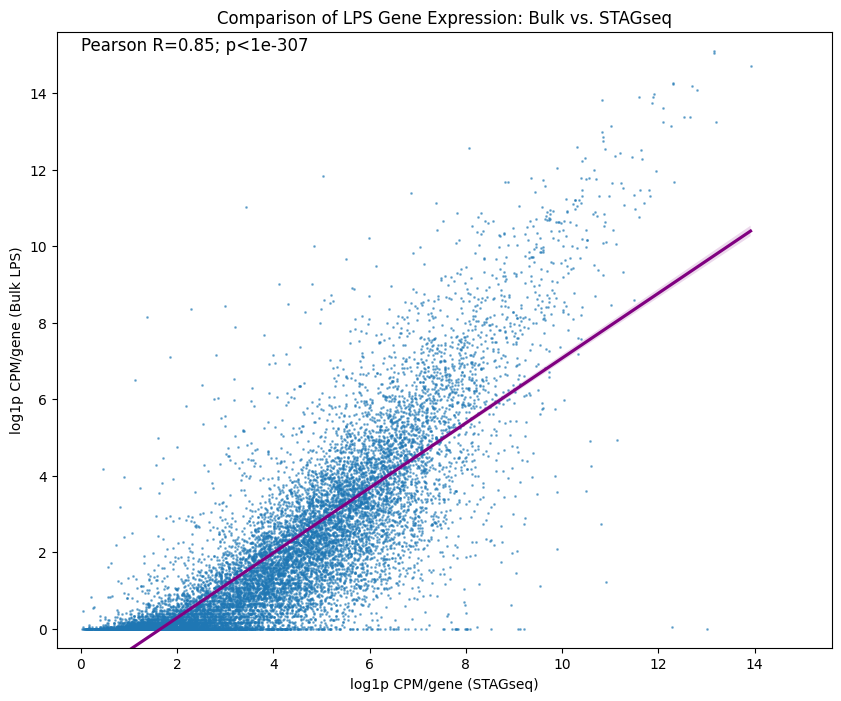

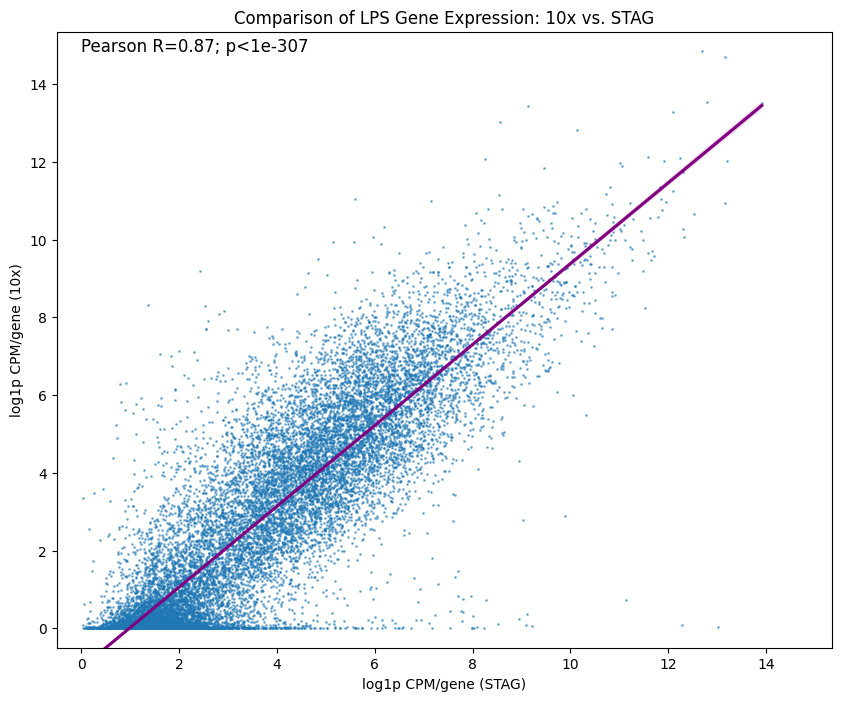

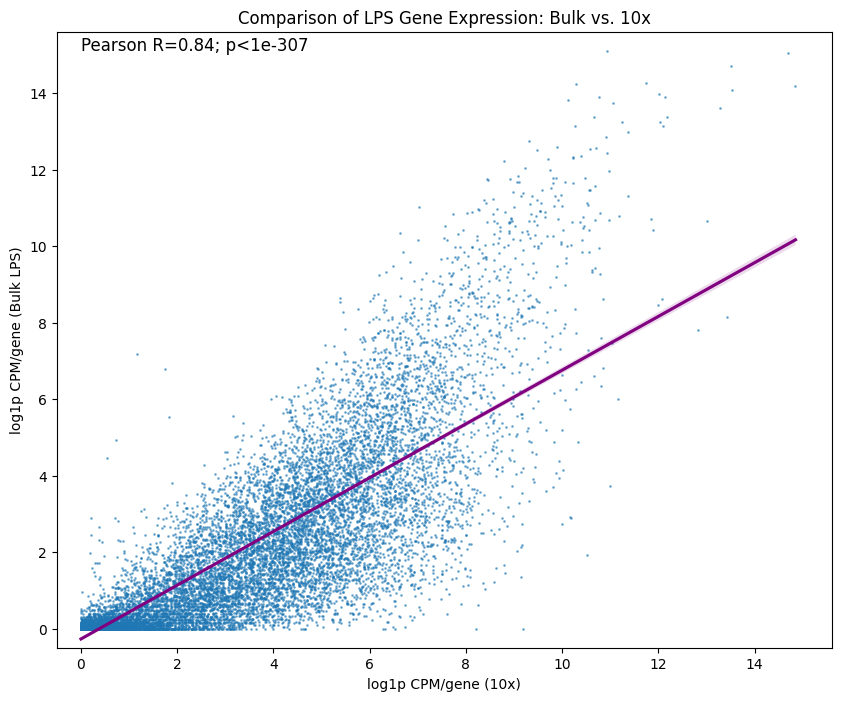

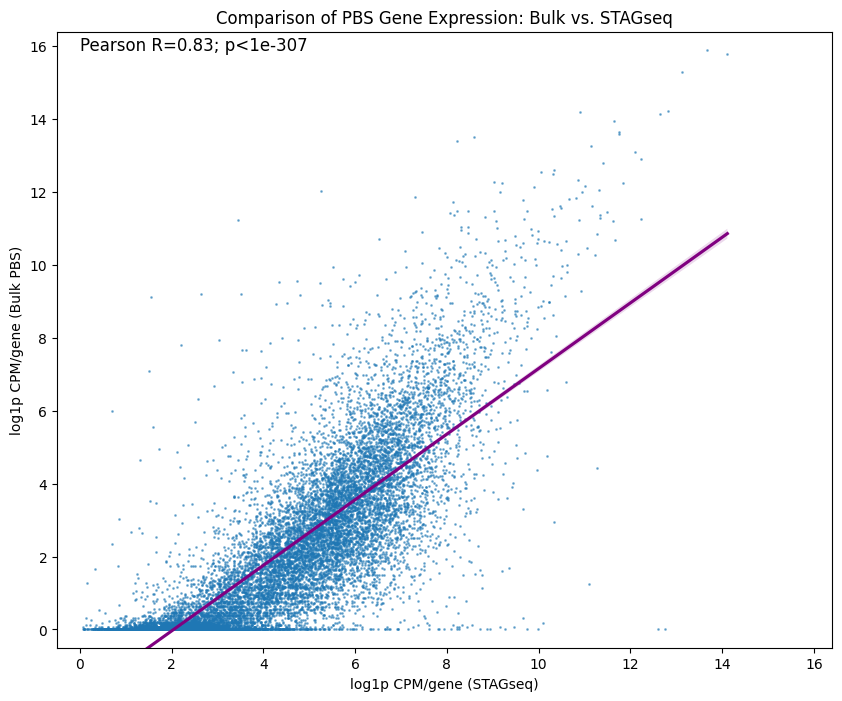

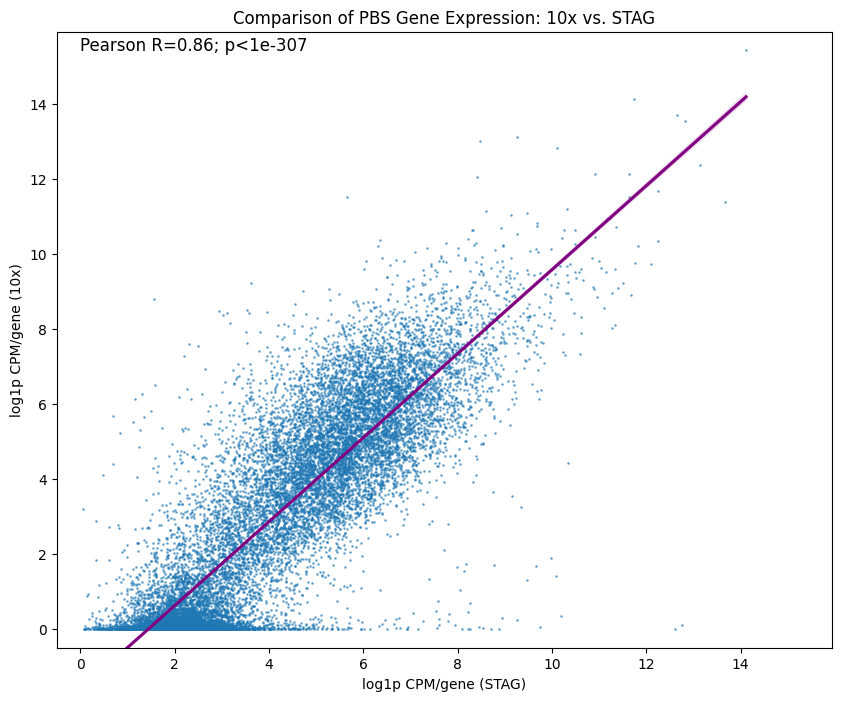

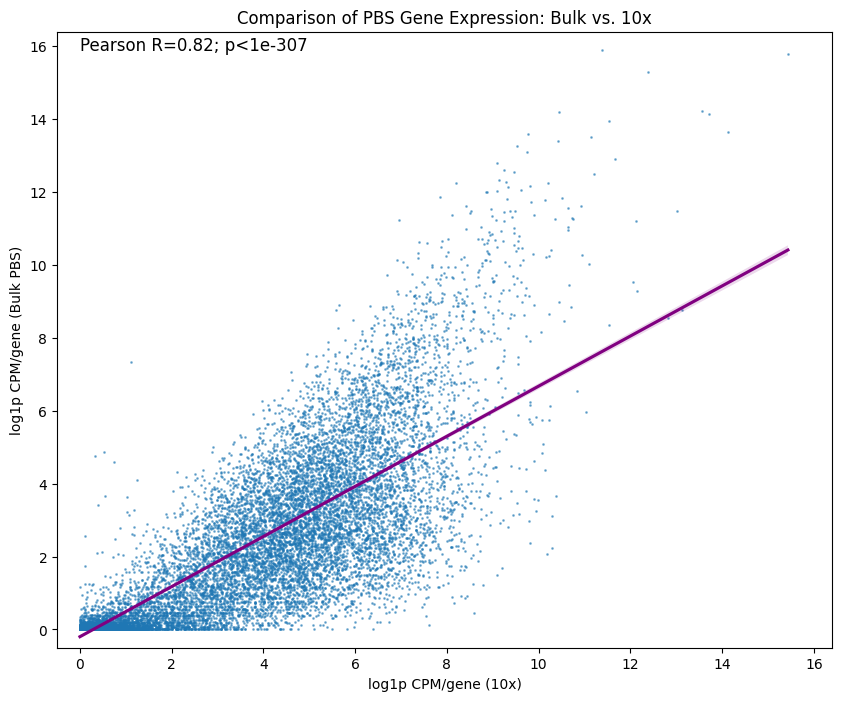

In [5]:
# plot the relative expression
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# ------------------------------------------------------------------------------
#                                DATA READERS
# ------------------------------------------------------------------------------
def read_and_preprocess_10x_data(data_path):
    adata = sc.read_10x_mtx(data_path)
    sc.pp.normalize_total(adata, target_sum=1e6)

    # Convert to pandas
    count_10x = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)
    count_10x.columns = count_10x.columns.str.upper()

    # Pseudo-bulk: average across all cells
    pseudo_count_10x = count_10x.mean(axis=0)
    return count_10x, pseudo_count_10x

def read_and_preprocess_bulk_table(bulk_file_path):
    """
    Read and preprocess the bulk file, returning a DataFrame with columns:
      [
        "GENE", 
        "Sum_LPS", "Sum_PBS",
        "CPM_LPS", "CPM_PBS",
        "log2_CPM_LPS", "log2_CPM_PBS"
      ]
    """
    table = pd.read_csv(bulk_file_path)
    # Calculate the total counts per condition for normalization
    total_LPS_counts = table[['MDM_LPS1', 'MDM_LPS2', 'MDM_LPS3']].sum().sum()
    total_PBS_counts = table[['MDM_PBS1', 'MDM_PBS2', 'MDM_PBS3']].sum().sum()

    # Sum the counts for each gene across the LPS and PBS samples
    table['Sum_LPS'] = table[['MDM_LPS1', 'MDM_LPS2', 'MDM_LPS3']].sum(axis=1)
    table['Sum_PBS'] = table[['MDM_PBS1', 'MDM_PBS2', 'MDM_PBS3']].sum(axis=1)

    # Calculate CPM for each gene
    table['CPM_LPS'] = (table['Sum_LPS'] / total_LPS_counts) * 1e6
    table['CPM_PBS'] = (table['Sum_PBS'] / total_PBS_counts) * 1e6

    # log2 transform
    table['log2_CPM_LPS'] = np.log2(table['CPM_LPS'] + 1)
    table['log2_CPM_PBS'] = np.log2(table['CPM_PBS'] + 1)
    
    # Make sure GENE is uppercase
    table["GENE"] = table["GENE"].str.upper()
    return table

def read_and_preprocess_STAG_pseudobulk(stag_path):
    """
    Read the STAG-seq data, normalize, return a (count_df, pseudo_bulk) pair.
    """
    LPS_scanpy = sc.read(stag_path)
    sc.pp.normalize_total(LPS_scanpy, target_sum=1e6)

    # Convert to pandas
    count_stag = pd.DataFrame(LPS_scanpy.X, columns=LPS_scanpy.var_names)
    count_stag.columns = count_stag.columns.str.upper()

    # Pseudo-bulk: average across all cells
    pseudoBulk_stag = count_stag.mean(axis=0)
    return count_stag, pseudoBulk_stag

# ------------------------------------------------------------------------------
#                           UNIFIED MERGE FUNCTION
# ------------------------------------------------------------------------------
def merge_bulk_stag_10x(
    bulk_table: pd.DataFrame,
    count_stag: pd.DataFrame,
    pseudoBulk_stag: pd.Series,
    count_10x: pd.DataFrame,
    pseudoBulk_10x: pd.Series,
    condition: str = "LPS"
) -> pd.DataFrame:
    """
    Merge Bulk, STAG, and 10x data in a single pass, returning a DataFrame
    with columns:
      ['log2_CPM_{condition}', 'STAG', 'log2_UMI_stag', '10x', 'log2_UMI_10x']
    Only genes found in all three data sources (Bulk, STAG, 10x) will be kept.
    
    Parameters
    ----------
    bulk_table : pd.DataFrame
        Must contain columns "GENE" and "log2_CPM_{condition}"
    count_stag : pd.DataFrame
        STAG count table; each column is a gene
    pseudoBulk_stag : pd.Series
        STAG pseudobulk counts, with index as gene
    count_10x : pd.DataFrame
        10x count table; each column is a gene
    pseudoBulk_10x : pd.Series
        10x pseudobulk counts, with index as gene
    condition : str
        Either "LPS" or "PBS" (whatever column is present in the bulk_table).

    Returns
    -------
    merged_df : pd.DataFrame
        DataFrame indexed by GENE, containing the relevant columns from all three.
    """
    # 1) Set index on the bulk table
    bulk_table_indexed = bulk_table.set_index("GENE")

    # 2) Determine common genes among all three
    common_genes = (
        bulk_table_indexed.index
        .intersection(count_stag.columns)
        .intersection(count_10x.columns)
    )

    # 3) Subset everything to common genes
    #    For Bulk, we only need the log2_CPM_{condition} column
    bulk_sub = bulk_table_indexed.loc[common_genes, f'log2_CPM_{condition}'].to_frame()

    #    For STAG, we want the raw pseudobulk and log2_UMI
    pseudoBulk_stag_sub = pseudoBulk_stag.loc[common_genes].to_frame(name='STAG')
    pseudoBulk_stag_sub['log2_UMI_stag'] = np.log2(pseudoBulk_stag_sub['STAG'] + 1)

    #    For 10x, we want the raw pseudobulk and log2_UMI
    pseudoBulk_10x_sub = pseudoBulk_10x.loc[common_genes].to_frame(name='10x')
    pseudoBulk_10x_sub['log2_UMI_10x'] = np.log2(pseudoBulk_10x_sub['10x'] + 1)

    # 4) Merge them all in ONE pass
    merged_df = pd.concat(
        [bulk_sub, pseudoBulk_stag_sub, pseudoBulk_10x_sub],
        axis=1
    )

    return merged_df

# ------------------------------------------------------------------------------
#                         COMPARISON / PLOTTING HELPERS
# ------------------------------------------------------------------------------
def plot_bulk_vs_stag(merged_data, condition="LPS", figname="bulk_stag_comparison", method="STAGseq", save_path="gene_expression_correlation"):
    """
    Compare Bulk vs. STAG on a scatter plot, using columns:
      x = 'log2_UMI_stag'
      y = f'log2_CPM_{condition}'
    """
    plt.figure(figsize=(10, 8))
    xvals = merged_data['log2_UMI_stag']
    yvals = merged_data[f'log2_CPM_{condition}']

    plt.scatter(xvals, yvals, alpha=0.5, s=1)

    corr, pval = pearsonr(xvals, yvals)
    sns.regplot(x=xvals, y=yvals, scatter=False, color='purple')

    plt.title(f'Comparison of {condition} Gene Expression: Bulk vs. {method}')
    plt.xlabel(f"log1p CPM/gene ({method})")
    plt.ylabel(f"log1p CPM/gene (Bulk {condition})")

    # plt.grid(True)
    # Ensure x and y are on the same scale
    common_min = min(xvals.min(), yvals.min())
    common_max = max(xvals.max(), yvals.max())
    plt.xlim(common_min-0.5, common_max+0.5)
    plt.ylim(common_min-0.5, common_max+0.5)

    # Add correlation to plot
    if pval < 1e-307:
        plt.text(
            common_min, common_max,
            f'Pearson R={corr:.2f}; p<1e-307',
            color='black', size=12
        )
    else:
        plt.text(
            common_min, common_max,
            f'Pearson R={corr:.2f}; p={pval:.2e}',
            color='black', size=12
        )
    
    # plt.savefig(f"{save_path}/{figname}.png", dpi=300)
    # plt.savefig(f"{save_path}/{figname}.svg", dpi=300)
    plt.show()
    plt.close()






def plot_10x_vs_stag(merged_data, condition="LPS", figname="10x_stag_comparison",  save_path="gene_expression_correlation"):
    """
    Compare 10x vs. STAG on a scatter plot, using columns:
      x = 'log2_UMI_stag'
      y = 'log2_UMI_10x'
    """
    plt.figure(figsize=(10, 8))
    xvals = merged_data['log2_UMI_stag']
    yvals = merged_data['log2_UMI_10x']

    plt.scatter(xvals, yvals, alpha=0.5, s=1)

    corr, pval = pearsonr(xvals, yvals)
    sns.regplot(x=xvals, y=yvals, scatter=False, color='purple')

    plt.title(f'Comparison of {condition} Gene Expression: 10x vs. STAG')
    plt.xlabel("log1p CPM/gene (STAG)")
    plt.ylabel("log1p CPM/gene (10x)")
    # plt.grid(True)
    # Ensure x and y are on the same scale
    common_min = min(xvals.min(), yvals.min())
    common_max = max(xvals.max(), yvals.max())
    plt.xlim(common_min-0.5, common_max+0.5)
    plt.ylim(common_min-0.5, common_max+0.5)

    # Add correlation to plot
    if pval < 1e-307:
        plt.text(
            common_min, common_max,
            f'Pearson R={corr:.2f}; p<1e-307',
            color='black', size=12
        )
    else:
        plt.text(
            common_min, common_max,
            f'Pearson R={corr:.2f}; p={pval:.2e}',
            color='black', size=12
        )
    
    # plt.savefig(f"{save_path}/{figname}.png", dpi=300)
    # plt.savefig(f"{save_path}/{figname}.svg", dpi=300)
    plt.show()
    plt.close()



def plot_bulk_vs_10x(
    merged_data: pd.DataFrame,
    condition: str = "LPS",
    figname: str = "bulk_vs_10x",
    method: str = "10x",
    save_path="gene_expression_correlation"
):
    """
    Compare Bulk vs. 10x on a scatter plot, using columns:
      x = 'log2_UMI_10x'
      y = f'log2_CPM_{condition}'
    """
    plt.figure(figsize=(10, 8))
    
    xvals = merged_data["log2_UMI_10x"]
    yvals = merged_data[f"log2_CPM_{condition}"]

    # Scatter plot
    plt.scatter(xvals, yvals, alpha=0.5, s=1)

    # Pearson correlation
    corr, pval = pearsonr(xvals, yvals)
    
    # Optional regression line
    sns.regplot(x=xvals, y=yvals, scatter=False, color='purple')

    # Title, axis labels, grid
    plt.title(f"Comparison of {condition} Gene Expression: Bulk vs. {method}")
    plt.xlabel("log1p CPM/gene (10x)")
    plt.ylabel(f"log1p CPM/gene (Bulk {condition})")
    # plt.grid(True)
    # Ensure x and y are on the same scale
    common_min = min(xvals.min(), yvals.min())
    common_max = max(xvals.max(), yvals.max())
    plt.xlim(common_min-0.5, common_max+0.5)
    plt.ylim(common_min-0.5, common_max+0.5)

    # Annotate correlation on the figure
    if pval < 1e-307:
        plt.text(
            common_min, common_max,
            f'Pearson R={corr:.2f}; p<1e-307',
            color='black', size=12
        )
    else:
        plt.text(
            common_min, common_max,
            f'Pearson R={corr:.2f}; p={pval:.2e}',
            color='black', size=12
        )

    # plt.savefig(f"{save_path}/{figname}.png", dpi=300)
    # plt.savefig(f"{save_path}/{figname}.svg", dpi=300)
    plt.show()
    plt.close()




# ------------------------------------------------------------------------------
#                                    MAIN
# ------------------------------------------------------------------------------
def main():
    # 1) File paths
    bulk_file_path = "/mnt/data/project/wholeTranscriptomicsFigure_stag/bulk_data/MDM_RNA_count_matrix_bulk.csv"
    LPS_stag_path = "/mnt/data/project/25_02_25_whole_transcriptomics/result/LPS/merged_LPS.h5ad"
    PBS_stag_path = "/mnt/data/project/25_02_25_whole_transcriptomics/result/PBS/merged_PBS.h5ad"
    path_to_10x_folder_PBS_1 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_39_027"
    path_to_10x_folder_PBS_2 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_40_034"
    path_to_10x_folder_LPS_1 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_41_016"
    path_to_10x_folder_LPS_2 = "/mnt/data/project/wholeTranscriptomicsFigure_stag/10x_baseline_data/subset_42_016"

    # 2) Read Bulk
    bulk_table = read_and_preprocess_bulk_table(bulk_file_path)

    # 3) Read STAG LPS/PBS
    LPS_count_stag, pseudoBulk_LPS_stag = read_and_preprocess_STAG_pseudobulk(LPS_stag_path)
    PBS_count_stag, pseudoBulk_PBS_stag = read_and_preprocess_STAG_pseudobulk(PBS_stag_path)

    # 4) Read 10x
    count_10x_39, pseudoBulk_10x_39 = read_and_preprocess_10x_data(path_to_10x_folder_PBS_1)
    count_10x_40, pseudoBulk_10x_40 = read_and_preprocess_10x_data(path_to_10x_folder_PBS_2)
    count_10x_41, pseudoBulk_10x_41 = read_and_preprocess_10x_data(path_to_10x_folder_LPS_1)
    count_10x_42, pseudoBulk_10x_42 = read_and_preprocess_10x_data(path_to_10x_folder_LPS_2)

    # --------------------------------------------------------------------------
    # Merge all (Bulk, STAG, 10x) for LPS
    # --------------------------------------------------------------------------
    merged_LPS = merge_bulk_stag_10x(
        bulk_table=bulk_table,
        count_stag=LPS_count_stag,
        pseudoBulk_stag=pseudoBulk_LPS_stag,
        count_10x=count_10x_41,
        pseudoBulk_10x=pseudoBulk_10x_41,
        condition="LPS"
    )

    # Plot: Bulk vs STAG (LPS)
    plot_bulk_vs_stag(
        merged_data=merged_LPS,
        condition="LPS",
        figname="bulk_vs_STAG_LPS",
        method="STAGseq"
    )

    # Plot: 10x vs STAG (LPS)
    plot_10x_vs_stag(
        merged_data=merged_LPS,
        condition="LPS",
        figname="10x_vs_STAG_LPS"
    )

    plot_bulk_vs_10x(
        merged_data=merged_LPS,
        condition="LPS",
        figname="bulk_vs_10x_LPS",
        method="10x"
    )

    
    # --------------------------------------------------------------------------
    # Merge all (Bulk, STAG, 10x) for PBS
    # --------------------------------------------------------------------------
    merged_PBS = merge_bulk_stag_10x(
        bulk_table=bulk_table,
        count_stag=PBS_count_stag,
        pseudoBulk_stag=pseudoBulk_PBS_stag,
        count_10x=count_10x_39,
        pseudoBulk_10x=pseudoBulk_10x_39,
        condition="PBS"
    )
    # import pdb; pdb.set_trace()
    
    # Plot: Bulk vs STAG (PBS)
    plot_bulk_vs_stag(
        merged_data=merged_PBS,
        condition="PBS",
        figname="bulk_vs_STAG_PBS",
        method="STAGseq"
    )
    # Plot: 10x vs STAG (PBS)
    plot_10x_vs_stag(
        merged_data=merged_PBS,
        condition="PBS",
        figname="10x_vs_STAG_PBS"
    )

    plot_bulk_vs_10x(
        merged_data=merged_PBS,
        condition="PBS",
        figname="bulk_vs_10x_PBS",
        method="10x"
    )


    

if __name__ == "__main__":
    main()
